# Connect to Drive

In [0]:
# #Step 1 part 1: connect to drive
# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse
# from google.colab import auth
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()
# import getpass
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
# !mkdir -p drive
# !google-drive-ocamlfuse drive

# Import Packages

In [0]:
import numpy as np
import pandas as pd

import os 
from os import walk
from os import path

import glob
import sys
import math
import re

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup

from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, LSTM, GRU, Dropout, Flatten
from keras.layers.embeddings import Embedding
from keras import optimizers
from keras import applications, optimizers
from keras.utils import np_utils
from keras.models import model_from_json
from keras.models import load_model
from keras.utils import plot_model

# Declare Paths

In [0]:
Data = '/content/'
# Data = '/media/protik/Drive E/Pipilika/DataSets/Data/'
Codes = '/media/protik/Drive E/Pipilika/Codes/News Classification/'

# Load DataFrame

In [0]:
df = pd.read_csv('{}{}'.format(Data,"data.csv"))
df.head()

,News,Class
0,"ঢাকা, অক্টোবর ০৭ (বিডিনিউজ টোয়েন্টিফোর ডটকম) -...",sports
1,যে বিশ্বকাপে হামেশাই ৩০০ পেরোনো ইনিংসের দেখা ম...,sports
2,ক্রিকেটের শ্রেষ্ঠত্ব বিচারের সর্বোচ্চ মঞ্চ হলো...,sports
3,আট বছর আগের দুঃস্মৃতি আজও বুকে শেল বিঁধিয়ে দে...,sports
4,"ঢাকা, জানুয়ারি ৩০ (বিডিনিউজ টোয়েন্টিফোর ডটকম) ...",sports


In [0]:
df.shape

(22674, 2)

# Analyse Data

### Number of News for Each Group

In [0]:
def bar_plot(l):
    keys, counts = np.unique(l, return_counts=True)
    plt.barh(keys, counts)
    plt.figure(figsize=(15,20))
    plt.show()

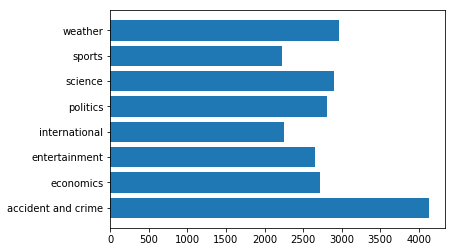

<Figure size 1080x1440 with 0 Axes>

In [0]:
classes = df['Class']
bar_plot(classes)

### Check for NaN Values

In [0]:
news_length = df['News'].str.len()
news_length = list(news_length)

found = False

for i in range(0,len(news_length)):
    x = news_length[i]
    if(np.isnan(x)):
        found = True
        print("Found a NaN value here: ", i)
        print("Class for this NaN value is: ", df['Class'][i])
        
if(not found):
    print("No NaN Value Found")

No NaN Value Found


### News Length Distribution

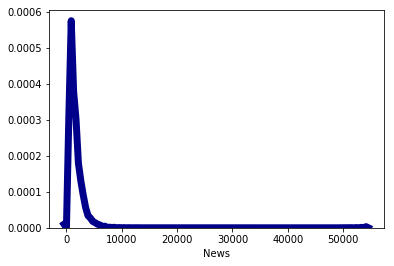

In [0]:
sns.distplot(df['News'].str.len(), hist=False, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'darkblue'},
             kde_kws={'linewidth': 7})

# Preprocessing

### Remove HTML Tags

In [0]:
def remove_html_tags(raw_review):
    review_text = BeautifulSoup(raw_review,'lxml').get_text()
    return review_text

df['News'] = [remove_html_tags(i) for i in df['News']]

### Remove Punctuations, Brackets and Special Characters

In [0]:
punctuation_signs = list('!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')

for punct_sign in punctuation_signs:
    df['News'] = df['News'].str.replace(punct_sign, ' ')

### Remove Escape Characters

In [0]:
def escape_ansi(line):
    line = line.replace('\n','')
    line = line.replace('\t','')
    line = line.replace("\'",'')
    line = line.replace("\"",'')
    line = line.replace("‘",'')
    line = line.replace("’",'')
    line = line.replace("  ",' ')
    line = line.replace("\xa0",' ')
    line = line.replace("\u2008",' ')
    return line

df['News'] = [escape_ansi(i) for i in df['News']]

### Remove Numbers

In [0]:
def escape_ansi(line):
    line = re.sub('[০-৯]+', 'সংখ্যা', line)
    line = re.sub('[0-9]+', 'সংখ্যা', line)
    return line

df['News'] = [escape_ansi(i) for i in df['News']]

### Embedding

In [0]:
def class_embedding(i):
    if(i=='accident and crime'):
        return 0
    elif(i=='economics'):
        return 1
    elif(i=='entertainment'):
        return 2
    elif(i=='international'):
        return 3
    elif(i=='politics'):
        return 4
    elif(i=='science'):
        return 5
    elif(i=='sports'):
        return 6
    elif(i=='weather'):
        return 7
        
df['Class'] = [class_embedding(i) for i in df['Class']]

### Shuffle DataSet

In [0]:
df = df.sample(frac=1).reset_index(drop=True)

In [0]:
df.head(10)

,News,Class
0,ঢাকা আগস্ট সংখ্যা বিডিনিউজ টোয়েন্টিফোর ডটকম ঢ...,7
1,ভারতের পশ্চিমবঙ্গে সোয়াইন ফ্লুতে আক্রান্ত হয়ে...,3
2,বাংলাদেশের রপ্তানিমুখী শিল্পকে সহায়তা দিতে বিশ...,1
3,মঈনুল হক চৌধুরী শহীদুল ইসলাম আশিক হোসেন ও আবুল...,5
4,জানুয়ারিতে ফ্রান্সের প্যারিসে সন্ত্রাসী হামলা...,3
5,মুক্তিযুদ্ধবিষয়কমন্ত্রী আ ক ম মোজাম্মেল হক মু...,4
6,সারা দেশের অধিকাংশ এলাকায় আরও বৃষ্টি হতে পারে...,7
7,ফেনীর সীমান্ত এলাকা ছাগলনাইয়ার যশপুর থেকে বর্...,0
8,ইরানের পরমাণু কর্মসূচির অগ্রগতি নিয়ে ইসরায়েলি ...,3
9,প্রযুক্তিবিষয়ক সাইট ম্যাকরিউমার্স জানিয়েছে সংখ...,5


### Splitting Train and Test Set

In [0]:
x_train = df.loc[:15999, 'News'].values
y_train = df.loc[:15999, 'Class'].values
x_test = df.loc[16000:, 'News'].values
y_test = df.loc[16000:, 'Class'].values

In [0]:
tokenizer_obj = Tokenizer()
total_news = df['News'].tolist()
tokenizer_obj.fit_on_texts(total_news)

max_length = max([len(s.split()) for s in total_news])
vocab_size = len(tokenizer_obj.word_index) + 1

print(max_length,vocab_size)

x_train_tokens = tokenizer_obj.texts_to_sequences(x_train)
x_test_tokens = tokenizer_obj.texts_to_sequences(x_test)

x_train_pad = pad_sequences(x_train_tokens, maxlen=max_length, padding='post')
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_length, padding='post')

8286 204315


In [0]:
print(len(x_test_pad))
print(len(x_train_pad))
print(y_train[0])
print(y_test[0])
print(len(y_test))

6674
16000
7
2
6674


# Build Model

In [0]:
EMBEDDING_DIM = 100

model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length))
model.add(GRU(units=512))
model.add(Dense(8, activation='softmax'))

# optimizer 
# adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train Model

### One Hot Encoding

In [0]:
def one_hot(y_train, y_test, n_classes):
    y_train = np_utils.to_categorical(y_train, n_classes)
    y_test = np_utils.to_categorical(y_test, n_classes)

    return y_train, y_test

In [0]:
y_train, y_test = one_hot(y_train, y_test, 8)

model.fit(x_train_pad, y_train, batch_size=64, epochs=20, validation_data=(x_test_pad,y_test), verbose=2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 16000 samples, validate on 6674 samples
Epoch 1/20
 - 3221s - loss: 2.0645 - acc: 0.1812 - val_loss: 2.0619 - val_acc: 0.1826
Epoch 2/20
 - 3106s - loss: 2.0630 - acc: 0.1823 - val_loss: 2.0639 - val_acc: 0.1826
Epoch 3/20
 - 3063s - loss: 2.0631 - acc: 0.1823 - val_loss: 2.0645 - val_acc: 0.1826
Epoch 4/20
 - 3081s - loss: 2.0621 - acc: 0.1823 - val_loss: 2.0640 - val_acc: 0.1826
Epoch 5/20
 - 3106s - loss: 2.0626 - acc: 0.1823 - val_loss: 2.0625 - val_acc: 0.1826
Epoch 6/20
 - 3163s - loss: 2.0623 - acc: 0.1823 - val_loss: 2.0623 - val_acc: 0.1826
Epoch 7/20
 - 3244s - loss: 2.0622 - acc: 0.1823 - val_loss: 2.0636 - val_acc: 0.1826
Epoch 8/20
 - 3255s - loss: 2.0678 - acc: 0.1799 - val_loss: 2.0617 - val_acc: 0.1826
Epoch 9/20
